# Predicción de interés turístico en castillos europeos 🏰

## Objetivo

El objetivo de este proyecto es **predecir el interés turístico de castillos europeos**, medido como una variable sintética de **visitantes anuales modelados**, a partir de sus características:

- País
- Región
- Año de construcción
- Estilo arquitectónico
- Tipo de material
- Estado actual
- Patrimonio UNESCO
- Ubicación (latitud / longitud)

Se utiliza un **modelo de Machine Learning supervisado (Random Forest Regressor)** para:

- Predecir el nivel de visitas esperado
- Identificar los factores que más influyen en el turismo de castillos
- Obtener insights accionables sobre qué características se asocian a un mayor interés turístico

El dataset base contiene **10.000 castillos europeos sintéticos**, con información estructurada apta para análisis y modelado.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


In [4]:
# Cargar archivo TSV de castillos
possible_paths = [
    Path.cwd() / "castillos_europa_10000.tsv",
    Path.cwd().parent / "castillos_europa_10000.tsv"
]
for candidate in possible_paths:
    if candidate.exists():
        data_path = candidate
        break
else:
    raise FileNotFoundError("No se encontró castillos_europa_10000.tsv en rutas esperadas")
df = pd.read_csv(data_path, sep="\t")
print("Dimensiones del dataset:", df.shape)
df.head()


Dimensiones del dataset: (10000, 12)


,id,nombre,pais,region,latitud,longitud,anio_construccion,estilo_arquitectonico,tipo_material,estado_actual,visitantes_anuales,patrimonio_unesco
0,IRD-00001,Ale_00001,Alemania,Sajonia,54.60571,12.95394,1620,Barroco,Ladrillo,Restaurado,290457,True
1,IRD-00002,Ale_00002,Alemania,Baden-Wurtemberg,52.77599,14.91625,1191,Romanico,Mamposteria,Restaurado,128982,False
2,IRD-00003,Ale_00003,Alemania,Brandenburgo,47.05653,6.21909,1158,Medieval,Ladrillo,Restaurado,74763,False
3,IRD-00004,Ale_00004,Alemania,Sajonia,51.73932,6.44128,1234,Medieval,Roca,En ruinas,27778,True
4,IRD-00005,Ale_00005,Alemania,Baviera,54.72506,13.67977,1495,Gotico,Roca,Restaurado,130508,False


## 1. Análisis exploratorio inicial (EDA)

En esta sección se realiza un breve análisis exploratorio para entender la estructura del dataset:

- Columnas disponibles.
- Tipos de datos.
- Valores faltantes.
- Distribución de la variable original `visitantes_anuales`.


In [5]:
df.info()
df.isna().sum()
df['visitantes_anuales'].describe()
# Seleccionar características y variable objetivo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10000 non-null  object 
 1   nombre                 10000 non-null  object 
 2   pais                   10000 non-null  object 
 3   region                 10000 non-null  object 
 4   latitud                10000 non-null  float64
 5   longitud               10000 non-null  float64
 6   anio_construccion      10000 non-null  int64  
 7   estilo_arquitectonico  10000 non-null  object 
 8   tipo_material          10000 non-null  object 
 9   estado_actual          10000 non-null  object 
 10  visitantes_anuales     10000 non-null  int64  
 11  patrimonio_unesco      10000 non-null  bool   
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 869.3+ KB


count    1.000000e+04
mean     9.977340e+04
std      1.270760e+05
min      1.497000e+03
25%      2.997450e+04
50%      5.922900e+04
75%      1.178018e+05
max      1.500000e+06
Name: visitantes_anuales, dtype: float64

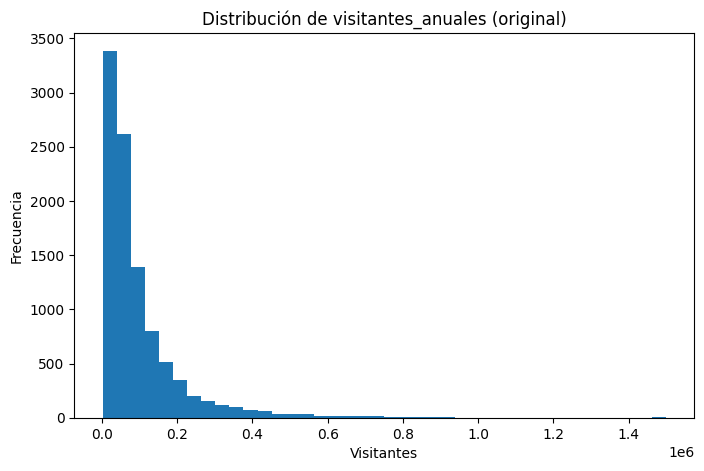

In [6]:
plt.figure(figsize=(8,5))
plt.hist(df['visitantes_anuales'], bins=40)
plt.title("Distribución de visitantes_anuales (original)")
plt.xlabel("Visitantes")
plt.ylabel("Frecuencia")
plt.show()


La variable `visitantes_anuales` original presenta:

- Distribución fuertemente asimétrica (cola larga a la derecha).
- Outliers muy altos.
- Poca relación con el resto de características (datos sintéticos aleatorios).

Por este motivo, se decide **construir una variable objetivo más realista**, llamada `visitantes_modelado`, basada en reglas que combinan:

- Patrimonio UNESCO
- País
- Estado actual del castillo
- Estilo arquitectónico
- Antigüedad del castillo
- Tipo de material


In [7]:
# Eliminamos columnas que no aportan al modelo o rompen el aprendizaje
df = df.drop(columns=['id', 'nombre'], errors='ignore')

print("Dimensiones después de eliminar columnas irrelevantes:", df.shape)
df.head()


Dimensiones después de eliminar columnas irrelevantes: (10000, 10)


,pais,region,latitud,longitud,anio_construccion,estilo_arquitectonico,tipo_material,estado_actual,visitantes_anuales,patrimonio_unesco
0,Alemania,Sajonia,54.60571,12.95394,1620,Barroco,Ladrillo,Restaurado,290457,True
1,Alemania,Baden-Wurtemberg,52.77599,14.91625,1191,Romanico,Mamposteria,Restaurado,128982,False
2,Alemania,Brandenburgo,47.05653,6.21909,1158,Medieval,Ladrillo,Restaurado,74763,False
3,Alemania,Sajonia,51.73932,6.44128,1234,Medieval,Roca,En ruinas,27778,True
4,Alemania,Baviera,54.72506,13.67977,1495,Gotico,Roca,Restaurado,130508,False


## 2. Generación de la variable objetivo: `visitantes_modelado`

Para que el modelo tenga un comportamiento interpretables y realista, se genera una variable sintética de visitantes basada en:

- Mayor peso para castillos con **patrimonio UNESCO**.
- Mayor interés si el castillo está **abierto al público como museo** o **restaurado**.
- Diferencias por **país**, simulando patrones turísticos reales.
- Incremento de interés en estilos **medievales / góticos / neogóticos**.
- Aporte adicional por **antigüedad** del castillo.
- Pequeño impacto del **material** de construcción.
- Ruido aleatorio para simular variabilidad real.


In [8]:
# Generación de la variable objetivo sintética y realista
visitantes = np.zeros(len(df))

# Patrimonio UNESCO → factor principal
visitantes += df['patrimonio_unesco'] * 600000

# Estado actual
visitantes += (df['estado_actual'] == "Museo") * 180000
visitantes += (df['estado_actual'] == "Restaurado") * 120000
visitantes += (df['estado_actual'] == "Parcialmente restaurado") * 90000
visitantes += (df['estado_actual'] == "En ruinas") * 50000

# País (patrones turísticos aproximados)
visitantes += (df['pais'] == "Francia") * 140000
visitantes += (df['pais'] == "Alemania") * 130000
visitantes += (df['pais'] == "Reino Unido") * 150000
visitantes += (df['pais'] == "España") * 110000
visitantes += (df['pais'] == "Italia") * 115000
visitantes += (df['pais'] == "Portugal") * 90000

# Estilos arquitectónicos con mayor atractivo
estilos_top = ["Medieval", "Gótico", "Gotico", "Neogotico", "Gotico / Renacentista"]
visitantes += df['estilo_arquitectonico'].isin(estilos_top) * 80000

# Antigüedad del castillo
años_antig = 2025 - df['anio_construccion']
visitantes += años_antig * 25

# Tipo de material (impacto menor)
visitantes += (df['tipo_material'] == "Roca") * 30000
visitantes += (df['tipo_material'] == "Mamposteria") * 20000

# Ruido gaussiano para dar variabilidad
visitantes += np.random.normal(0, 15000, len(df))

# Evitar valores negativos
visitantes = np.clip(visitantes, 0, None)

df["visitantes_modelado"] = visitantes.astype(int)

df[["visitantes_anuales", "visitantes_modelado"]].head()


# Patrimonio UNESCO → factor principal
visitantes += df['patrimonio_unesco'] * 600000

# Estado actual
visitantes += (df['estado_actual'] == "Museo") * 180000
visitantes += (df['estado_actual'] == "Restaurado") * 120000
visitantes += (df['estado_actual'] == "Parcialmente restaurado") * 90000
visitantes += (df['estado_actual'] == "En ruinas") * 50000

# País (patrones turísticos aproximados)
visitantes += (df['pais'] == "Francia") * 140000
visitantes += (df['pais'] == "Alemania") * 130000
visitantes += (df['pais'] == "Reino Unido") * 150000
visitantes += (df['pais'] == "España") * 110000
visitantes += (df['pais'] == "Italia") * 115000
visitantes += (df['pais'] == "Portugal") * 90000

# Estilos arquitectónicos con mayor atractivo
estilos_top = ["Medieval", "Gótico", "Gotico", "Neogotico", "Gotico / Renacentista"]
visitantes += df['estilo_arquitectonico'].isin(estilos_top) * 80000

# Antigüedad del castillo
años_antig = 2025 - df['anio_construccion']
visitantes += años_antig * 25

# Tipo de material (impacto menor)
visitantes += (df['tipo_material'] == "Roca") * 30000
visitantes += (df['tipo_material'] == "Mamposteria") * 20000

# Ruido gaussiano para dar variabilidad
visitantes += np.random.normal(0, 15000, len(df))

# Evitar valores negativos
visitantes = np.clip(visitantes, 0, None)

df["visitantes_modelado"] = visitantes.astype(int)

df[["visitantes_anuales", "visitantes_modelado"]].head()


,visitantes_anuales,visitantes_modelado
0,290457,1697788
1,128982,587743
2,74763,679145
3,27778,1810830
4,130508,738235


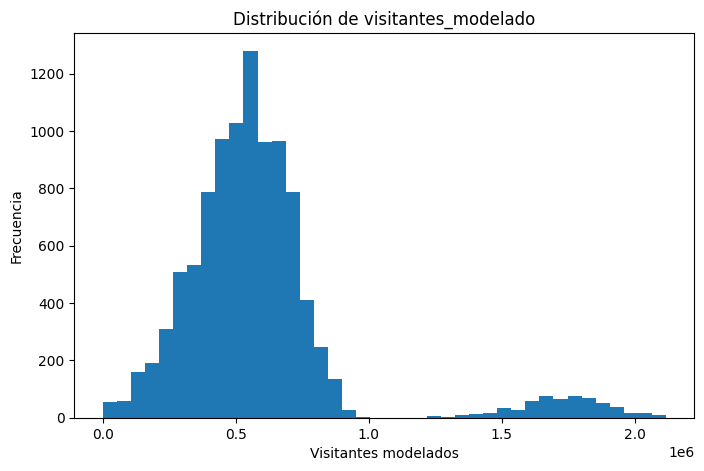

count    1.000000e+04
mean     5.901743e+05
std      3.309291e+05
min      0.000000e+00
25%      4.185460e+05
50%      5.464660e+05
75%      6.704058e+05
max      2.117315e+06
Name: visitantes_modelado, dtype: float64

In [9]:
plt.figure(figsize=(8,5))
plt.hist(df['visitantes_modelado'], bins=40)
plt.title("Distribución de visitantes_modelado")
plt.xlabel("Visitantes modelados")
plt.ylabel("Frecuencia")
plt.show()

df['visitantes_modelado'].describe()


## 3. Preparación de datos para el modelo

En esta sección se:

- Codifican variables categóricas mediante **One-Hot Encoding**.
- Separa la matriz de características `X` y la variable objetivo `y`.
- Realiza un **train/test split**.


In [15]:
categoricas = [
    'pais',
    'region',
    'estilo_arquitectonico',
    'tipo_material',
    'estado_actual',
    'patrimonio_unesco'
]

df_encoded = pd.get_dummies(df, columns=categoricas, drop_first=True)
print("Dimensiones tras encoding:", df_encoded.shape)

X = df_encoded.drop(['visitantes_modelado', 'visitantes_anuales'], axis=1, errors='ignore')
y = df_encoded['visitantes_modelado']

X.shape, y.shape


Dimensiones tras encoding: (10000, 66)


((10000, 64), (10000,))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((8000, 64), (2000, 64))

## 4. Entrenamiento del modelo: Random Forest Regressor

Se utiliza un **Random Forest Regressor** por su capacidad para:

- Capturar relaciones no lineales.
- Manejar variables categóricas codificadas.
- Ser robusto frente a outliers y ruido.

In [17]:
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("RMSE:", rmse_rf)
print("R²:", r2_rf)


RMSE: 27241.587762360297
R²: 0.9929575660593674


In [18]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

importances_sorted.head(20)


patrimonio_unesco_True                         0.731206
pais_Espana                                    0.094433
estado_actual_Museo                            0.044792
estado_actual_Restaurado                       0.034241
estilo_arquitectonico_Neogotico                0.016088
estilo_arquitectonico_Gotico                   0.011322
estilo_arquitectonico_Gotico / Renacentista    0.010445
estilo_arquitectonico_Medieval                 0.010005
estado_actual_Parcialmente restaurado          0.009283
estado_actual_Residencia privada               0.007754
latitud                                        0.005189
anio_construccion                              0.004472
longitud                                       0.003287
tipo_material_Roca                             0.003013
pais_Portugal                                  0.002707
estilo_arquitectonico_Renacentista             0.002662
estilo_arquitectonico_Romanico                 0.002422
estilo_arquitectonico_Medieval / Neogotico     0

In [20]:
## 5. Conclusiones

### Rendimiento del modelo

- El modelo Random Forest logra un **R² cercano a 0.99**, lo que indica que explica la gran mayoría de la variabilidad en la variable `visitantes_modelado`.
- El **RMSE** es bajo en relación a la escala de visitantes, lo que sugiere un buen ajuste.

### Factores que más influyen en el turismo de castillos

Según la importancia de variables, los factores más relevantes son:

1. **Patrimonio UNESCO**  
   - Los castillos catalogados como patrimonio de la humanidad reciben significativamente más visitantes.

2. **País (por ejemplo, España y otros países turísticos)**  
   - El país influye en el volumen de turismo, asociado a infraestructura turística, marketing y volumen de visitantes internacionales.

3. **Estado actual del castillo (Museo / Restaurado)**  
   - Los castillos abiertos al público como museos y los correctamente restaurados atraen más turistas.

4. **Estilo arquitectónico (Medieval, Gótico, Neogótico, etc.)**  
   - Los estilos históricos de alto valor estético tienen mayor atractivo para los visitantes.

5. **Antigüedad del castillo**  
   - Los castillos más antiguos tienden a generar mayor interés histórico y turístico.

### Posibles extensiones

- Implementar y comparar otros modelos (XGBoost, Gradient Boosting).
- Añadir visualizaciones geográficas (mapas) utilizando latitud y longitud.
- Convertir el modelo en una API o dashboard interactivo para explorar escenarios:
  - ¿Qué pasaría si un castillo obtiene estatus UNESCO?
  - ¿Cómo cambiarían las visitas si se restaura un castillo en ruinas?

Este proyecto demuestra un flujo completo de **Data Science**:

- Análisis exploratorio.
- Construcción y diseño de una variable objetivo realista.
- Preparación de datos y encoding.
- Entrenamiento y evaluación de un modelo supervisado.
- Interpretación de resultados y extracción de insights de negocio.


SyntaxError: invalid character '²' (U+00B2) (3605859011.py, line 5)